In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary, set_trainable
import gpflux
import gpflow
import tensorflow as tf

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data

tf.keras.backend.set_floatx("float64")

In [1]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)
pos_train, labels_train = get_xticks(df_train)
pos_test, labels_test = get_xticks(df_test)

2022-07-13 09:43:42.222287: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-13 09:43:42.802049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


# Deep GP model

/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
/tmp/ipykernel_4161898/2810889137.py:31: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2

Epoch 1/50


2022-07-13 09:43:51.186903: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x76c51a0


15/15 [==============================] - 8s 131ms/step - loss: 8.7141 - gp_layer_prior_kl: 1.4882e-06 - gp_layer_1_prior_kl: 6.6838e-05 - gp_layer_2_prior_kl: 9.4756e-07
Epoch 2/50
15/15 [==============================] - 2s 131ms/step - loss: 6.7985 - gp_layer_prior_kl: 2.0892e-05 - gp_layer_1_prior_kl: 4.8569e-04 - gp_layer_2_prior_kl: 7.1776e-06
Epoch 3/50
15/15 [==============================] - 2s 131ms/step - loss: 5.3634 - gp_layer_prior_kl: 6.5846e-05 - gp_layer_1_prior_kl: 0.0015 - gp_layer_2_prior_kl: 1.9903e-05
Epoch 4/50
15/15 [==============================] - 2s 131ms/step - loss: 4.3777 - gp_layer_prior_kl: 1.1513e-04 - gp_layer_1_prior_kl: 0.0033 - gp_layer_2_prior_kl: 3.8610e-05
Epoch 5/50
15/15 [==============================] - 2s 131ms/step - loss: 3.6956 - gp_layer_prior_kl: 1.4915e-04 - gp_layer_1_prior_kl: 0.0059 - gp_layer_2_prior_kl: 6.2334e-05
Epoch 6/50
15/15 [==============================] - 2s 131ms/step - loss: 3.2688 - gp_layer_prior_kl: 1.6983e-04 - gp_

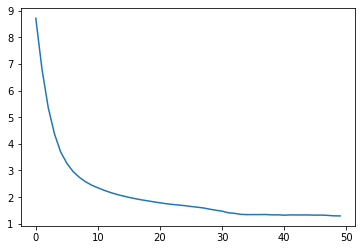

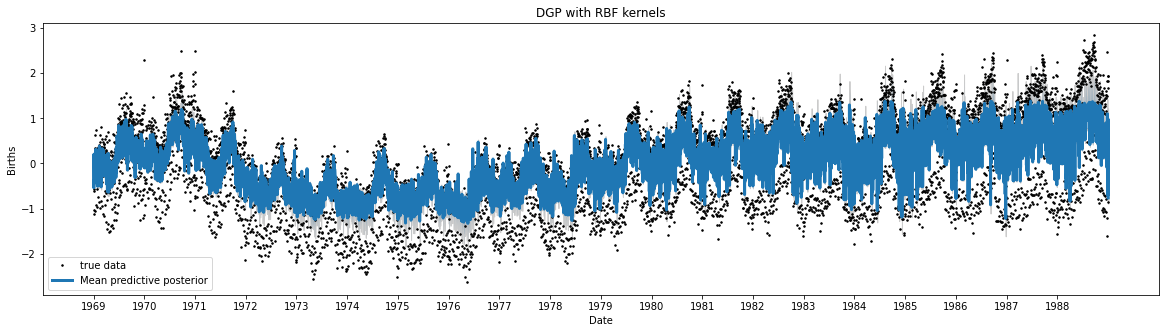

In [2]:
# from gpflux.architectures import Config, build_constant_input_dim_deep_gp
# from gpflux.models import DeepGP
num_inducing = 1000

Z = np.linspace(x.min(), x.max(), num_inducing).reshape(-1, 1)

kernel1 = gpflow.kernels.Matern52()
inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer1 = gpflux.layers.GPLayer(kernel1, inducing_variable1, num_data=len(x), num_latent_gps=y.shape[1])

kernel2 = gpflow.kernels.RBF() 
inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer2 = gpflux.layers.GPLayer(
    kernel2,
    inducing_variable2,
    num_data=len(x),
    num_latent_gps=y.shape[1],
    mean_function=gpflow.mean_functions.Zero(),
)

kernel3 = gpflow.kernels.RBF() 
inducing_variable3 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer3 = gpflux.layers.GPLayer(
    kernel3,
    inducing_variable3,
    num_data=len(x),
    num_latent_gps=y.shape[1],
    mean_function=gpflow.mean_functions.Zero(),
)

likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
two_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2, gp_layer3], likelihood_layer)

model = two_layer_dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.1))

history = model.fit({"inputs": x, "targets": y}, batch_size=500, epochs=50, verbose=1)
plt.plot(history.history["loss"])

model = two_layer_dgp.as_prediction_model()
output = model(x)
mu = output.f_mean.numpy().squeeze()
var = output.f_var.numpy().squeeze()

plt.figure(figsize=(20,5))
plt.plot(x, y, '.', label='true data', c='black', markersize=3)
plt.plot(x, mu, '-', label='Mean predictive posterior', c='C0', linewidth=3)
vv = 1.96 * np.sqrt(var) 
plt.fill_between(x[:,0], (mu-vv), (mu+vv), alpha=0.4, edgecolor='gray', facecolor='C0')
plt.title('DGP with RBF kernels' )
plt.xticks(pos, labels)
plt.xlabel('Date')
plt.ylabel('Births')
plt.legend()
plt.show()

/tmp/ipykernel_4161898/2574765576.py:38: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))


Epoch 1/50
15/15 [==============================] - 5s 91ms/step - loss: 4.7947 - gp_layer_21_prior_kl: 0.0033 - gp_layer_22_prior_kl: 0.0252
Epoch 2/50
15/15 [==============================] - 1s 89ms/step - loss: 1.6725 - gp_layer_21_prior_kl: 0.0093 - gp_layer_22_prior_kl: 0.1162
Epoch 3/50
15/15 [==============================] - 1s 89ms/step - loss: 1.3777 - gp_layer_21_prior_kl: 0.0035 - gp_layer_22_prior_kl: 0.1195
Epoch 4/50
15/15 [==============================] - 1s 89ms/step - loss: 1.3369 - gp_layer_21_prior_kl: 0.0010 - gp_layer_22_prior_kl: 0.1056
Epoch 5/50
15/15 [==============================] - 1s 90ms/step - loss: 1.3456 - gp_layer_21_prior_kl: 4.5385e-04 - gp_layer_22_prior_kl: 0.1086
Epoch 6/50
15/15 [==============================] - 1s 90ms/step - loss: 1.3696 - gp_layer_21_prior_kl: 3.4044e-04 - gp_layer_22_prior_kl: 0.1168
Epoch 7/50
15/15 [==============================] - 1s 89ms/step - loss: 1.3905 - gp_layer_21_prior_kl: 2.7911e-04 - gp_layer_22_prior_kl: 0

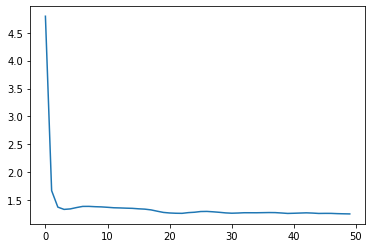

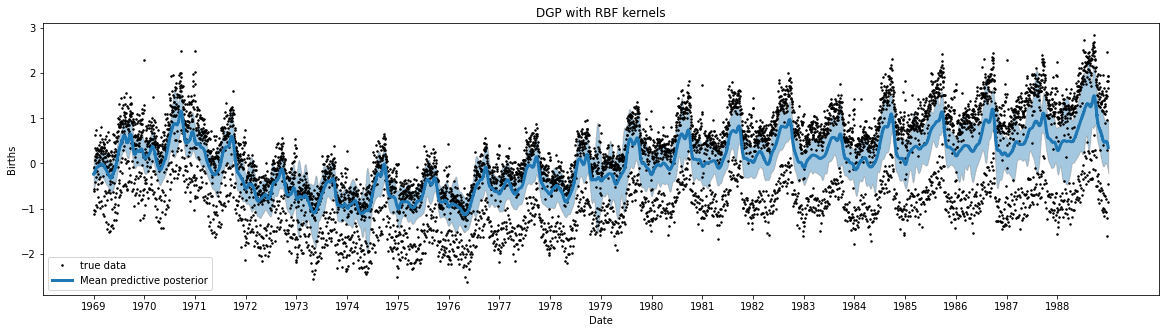

In [10]:
# from gpflux.architectures import Config, build_constant_input_dim_deep_gp
# from gpflux.models import DeepGP
x, y = separate_data(data, normalised=True)

x = x.numpy().reshape(-1,1)
y = y.numpy().reshape(-1,1)


def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

num_inducing = 1000

Z = np.linspace(x.min(), x.max(), num_inducing).reshape(-1, 1)

kernel1 = gpflow.kernels.Matern52()
inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer1 = gpflux.layers.GPLayer(kernel1, inducing_variable1, num_data=len(x), num_latent_gps=y.shape[1])

kernel2 = gpflow.kernels.RBF() 
inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer2 = gpflux.layers.GPLayer(
    kernel2,
    inducing_variable2,
    num_data=len(x),
    num_latent_gps=y.shape[1],
    mean_function=gpflow.mean_functions.Zero(),
)


likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
two_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2], likelihood_layer)

model = two_layer_dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.1))

history = model.fit({"inputs": x, "targets": y}, batch_size=500, epochs=50, verbose=1)
plt.plot(history.history["loss"])

model = two_layer_dgp.as_prediction_model()
output = model(x)
mu = output.f_mean.numpy().squeeze()
var = output.f_var.numpy().squeeze()

plt.figure(figsize=(20,5))
plt.plot(x, y, '.', label='true data', c='black', markersize=3)
plt.plot(x, mu, '-', label='Mean predictive posterior', c='C0', linewidth=3)
vv = 1.96 * np.sqrt(var) 
plt.fill_between(x[:,0], (mu-vv), (mu+vv), alpha=0.4, edgecolor='gray', facecolor='C0')
plt.title('DGP with RBF kernels' )
plt.xticks(pos, labels)
plt.xlabel('Date')
plt.ylabel('Births')
plt.legend()
plt.show()

In [3]:
x, y = separate_data(data, normalised=True, weekdays=True)

x = x.numpy().reshape(-1,1)
y = y.numpy().reshape(-1,1)


def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
/tmp/ipykernel_4161898/2459611603.py:31: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2

Epoch 1/50
11/11 [==============================] - 4s 88ms/step - loss: 5.0215 - gp_layer_3_prior_kl: 0.0026 - gp_layer_4_prior_kl: 0.0212
Epoch 2/50
11/11 [==============================] - 1s 87ms/step - loss: 1.6719 - gp_layer_3_prior_kl: 0.0125 - gp_layer_4_prior_kl: 0.1238
Epoch 3/50
11/11 [==============================] - 1s 88ms/step - loss: 1.2012 - gp_layer_3_prior_kl: 0.0110 - gp_layer_4_prior_kl: 0.1879
Epoch 4/50
11/11 [==============================] - 1s 87ms/step - loss: 1.0892 - gp_layer_3_prior_kl: 0.0040 - gp_layer_4_prior_kl: 0.1760
Epoch 5/50
11/11 [==============================] - 1s 88ms/step - loss: 1.0571 - gp_layer_3_prior_kl: 0.0018 - gp_layer_4_prior_kl: 0.1690
Epoch 6/50
11/11 [==============================] - 1s 88ms/step - loss: 1.0630 - gp_layer_3_prior_kl: 0.0012 - gp_layer_4_prior_kl: 0.1787
Epoch 7/50
11/11 [==============================] - 1s 88ms/step - loss: 1.0978 - gp_layer_3_prior_kl: 9.4312e-04 - gp_layer_4_prior_kl: 0.2001
Epoch 8/50
11/11

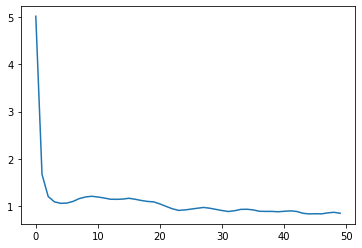

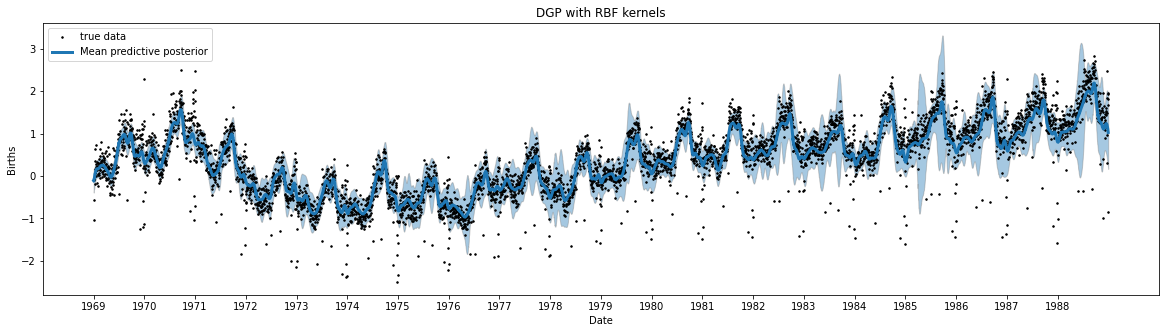

In [4]:
# from gpflux.architectures import Config, build_constant_input_dim_deep_gp
# from gpflux.models import DeepGP
num_inducing = 1000

Z = np.linspace(x.min(), x.max(), num_inducing).reshape(-1, 1)

kernel1 = gpflow.kernels.Matern52()
inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer1 = gpflux.layers.GPLayer(kernel1, inducing_variable1, num_data=len(x), num_latent_gps=y.shape[1])

kernel2 = gpflow.kernels.RBF() 
inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer2 = gpflux.layers.GPLayer(
    kernel2,
    inducing_variable2,
    num_data=len(x),
    num_latent_gps=y.shape[1],
    mean_function=gpflow.mean_functions.Zero(),
)

kernel3 = gpflow.kernels.RBF() 
inducing_variable3 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer3 = gpflux.layers.GPLayer(
    kernel3,
    inducing_variable3,
    num_data=len(x),
    num_latent_gps=y.shape[1],
    mean_function=gpflow.mean_functions.Zero(),
)

likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
two_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2], likelihood_layer)

model = two_layer_dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.1))

history = model.fit({"inputs": x, "targets": y}, batch_size=500, epochs=50, verbose=1)
plt.plot(history.history["loss"])

model = two_layer_dgp.as_prediction_model()
output = model(x)
mu = output.f_mean.numpy().squeeze()
var = output.f_var.numpy().squeeze()

plt.figure(figsize=(20,5))
plt.plot(x, y, '.', label='true data', c='black', markersize=3)
plt.plot(x, mu, '-', label='Mean predictive posterior', c='C0', linewidth=3)
vv = 1.96 * np.sqrt(var) 
plt.fill_between(x[:,0], (mu-vv), (mu+vv), alpha=0.4, edgecolor='gray', facecolor='C0')
plt.title('DGP with RBF kernels' )
plt.xticks(pos, labels)
plt.xlabel('Date')
plt.ylabel('Births')
plt.legend()
plt.show()

/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/cn321/.local/lib/python3.8/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
/tmp/ipykernel_4161898/4003382949.py:47: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2

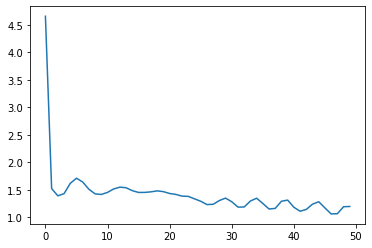

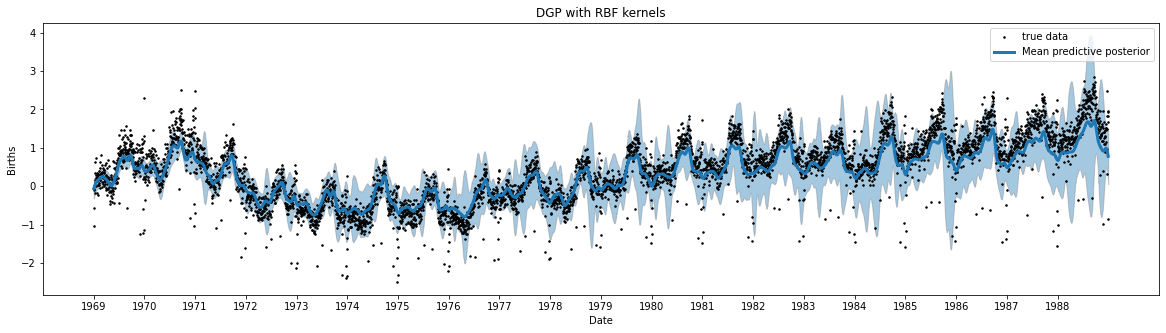

In [12]:
# from gpflux.architectures import Config, build_constant_input_dim_deep_gp
# from gpflux.models import DeepGP
x, y = separate_data(data, normalised=True, weekdays=True)

x = x.numpy().reshape(-1,1)
y = y.numpy().reshape(-1,1)


def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

num_inducing = 3000

Z = np.linspace(x.min(), x.max(), num_inducing).reshape(-1, 1)

kernel1 = gpflow.kernels.RBF() 
inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer1 = gpflux.layers.GPLayer(kernel1, inducing_variable1, num_data=len(x), num_latent_gps=y.shape[1])

kernel2 = gpflow.kernels.RBF()
inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer2 = gpflux.layers.GPLayer(
    kernel2,
    inducing_variable2,
    num_data=len(x),
    num_latent_gps=y.shape[1],
    mean_function=gpflow.mean_functions.Zero(),
)

kernel3 = gpflow.kernels.RBF() 
inducing_variable3 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer3 = gpflux.layers.GPLayer(
    kernel3,
    inducing_variable3,
    num_data=len(x),
    num_latent_gps=y.shape[1],
    mean_function=gpflow.mean_functions.Zero(),
)

likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
two_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2], likelihood_layer)

model = two_layer_dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.1))

history = model.fit({"inputs": x, "targets": y}, batch_size=500, epochs=50, verbose=0)
plt.plot(history.history["loss"])

model = two_layer_dgp.as_prediction_model()
output = model(x)
mu = output.f_mean.numpy().squeeze()
var = output.f_var.numpy().squeeze()

plt.figure(figsize=(20,5))
plt.plot(x, y, '.', label='true data', c='black', markersize=3)
plt.plot(x, mu, '-', label='Mean predictive posterior', c='C0', linewidth=3)
vv = 1.96 * np.sqrt(var) 
plt.fill_between(x[:,0], (mu-vv), (mu+vv), alpha=0.4, edgecolor='gray', facecolor='C0')
plt.title('DGP with RBF kernels' )
plt.xticks(pos, labels)
plt.xlabel('Date')
plt.ylabel('Births')
plt.legend()
plt.show()